## Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_data='/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6'

In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 10.9MB/s 
     |████████████████████████████████| 901kB 41.1MB/s 
     |████████████████████████████████| 3.3MB 38.2MB/s 


In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 11.4MB/s 


In [5]:
# Importing all the modules
import os
import csv
import pandas as pd
import numpy as np
import torch
import argparse
import pickle
import logging
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

In [6]:
df_label = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/labeled_2.csv')
df_unlabel = pd.read_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/unlabeled_2.csv')

In [7]:
df_unlabel.drop('Unnamed: 0', inplace = True, axis = 1)

In [8]:
df_label.drop('Unnamed: 0', inplace = True, axis = 1)

## Solving for Q1:

In [9]:
X_train, X_test = train_test_split(df_label, test_size=0.2, random_state=42)

In [10]:
unlabeled_ind = round(len(df_unlabel)*1)
# Partition the data
X_unlabeled = df_unlabel.iloc[:unlabeled_ind]

# Check dimensions of data after splitting
print(f"X_train dimensions: {X_train.shape}")
print(f"X_test dimensions: {X_test.shape}")
print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (364, 7)
X_test dimensions: (92, 7)
X_unlabeled dimensions: (7343, 1)


In [11]:
# train valid split
X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=42)

In [12]:
X_train.shape, X_test.shape, X_valid.shape

((327, 7), (92, 7), (37, 7))

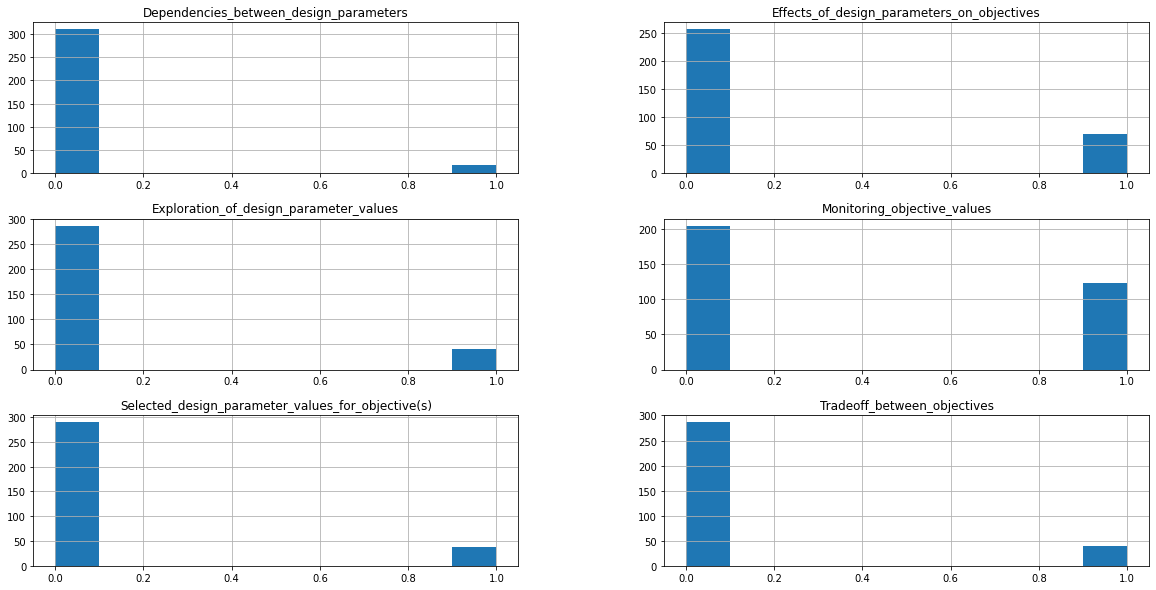

In [13]:
fig, ax = plt.subplots(figsize=(20, 10));
X_train[["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]].hist(ax=ax);

## Preprocess Data

In [14]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [15]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [16]:
train_text_list = X_train["full_text"].values
test_text_list = X_test["full_text"].values
valid_text_list = X_valid["full_text"].values
unlabeled_list = X_unlabeled["full_text"].values

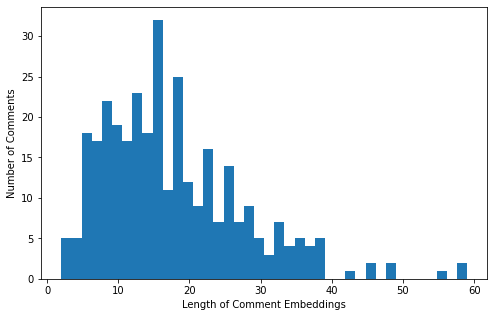

In [17]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

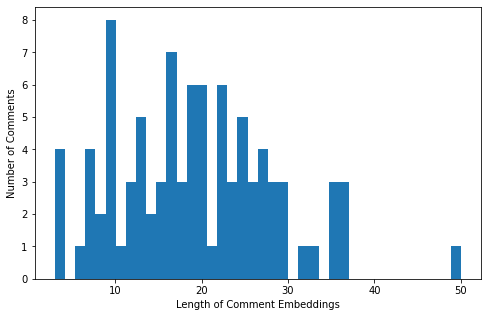

In [18]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

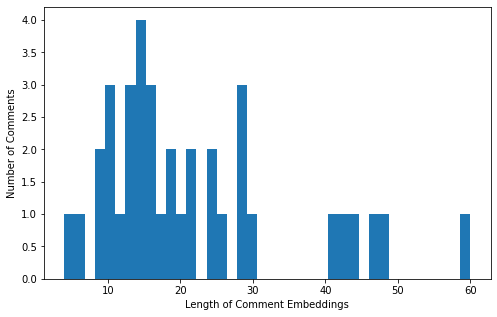

In [19]:
plot_sentence_embeddings_length(valid_text_list, tokenizer)

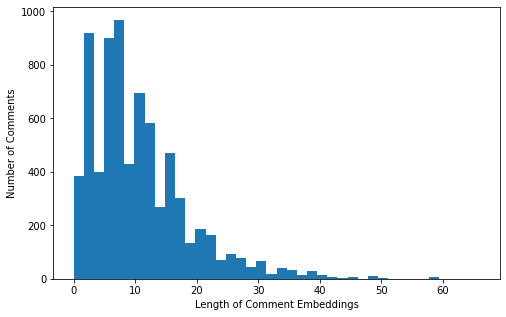

In [20]:
plot_sentence_embeddings_length(unlabeled_list, tokenizer)

In [21]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [22]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[ 160, 2624, 5523, ...,    0,    0,    0],
       [  18, 5926,  604, ...,    0,    0,    0],
       [  64,   44,  197, ...,    0,    0,    0],
       ...,
       [  80,   17,   88, ...,    0,    0,    0],
       [ 886,   61,   17, ...,    0,    0,    0],
       [  17, 3518,  112, ...,    0,    0,    0]])

In [23]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[ 2117,   290,    27, ...,     0,     0,     0],
       [   17,   150,   232, ...,     0,     0,     0],
       [  113,    27,    20, ...,     0,     0,     0],
       ...,
       [ 7693,    38,    24, ...,     0,     0,     0],
       [   17,   150,   232, ...,     0,     0,     0],
       [25159,  3350,  1168, ...,     0,     0,     0]])

In [24]:
# create input id tokens
valid_input_ids = tokenize_inputs(valid_text_list, tokenizer, num_embeddings=250)
valid_input_ids

array([[ 1115,  1021,    28, ...,     0,     0,     0],
       [  171,    17,  3518, ...,     0,     0,     0],
       [ 2395,   126,    18, ...,     0,     0,     0],
       ...,
       [  112,    44,   214, ...,     0,     0,     0],
       [   17,   150,   995, ...,     0,     0,     0],
       [   94, 10808,   811, ...,     0,     0,     0]])

In [25]:
# create input id tokens
unlabeled_input_ids = tokenize_inputs(unlabeled_list, tokenizer, num_embeddings=250)
unlabeled_input_ids

array([[   80,    47,  2712, ...,     0,     0,     0],
       [   47,    44,  3037, ...,     0,     0,     0],
       [   80,    47,  2712, ...,     0,     0,     0],
       ...,
       [  113,    75, 19387, ...,     0,     0,     0],
       [   81,    38,   421, ...,     0,     0,     0],
       [ 2153,    36,    24, ...,     0,     0,     0]])

In [26]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [27]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [28]:
# create attention masks
valid_attention_masks = create_attn_masks(valid_input_ids)
valid_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [29]:
# create attention masks
unlabeled_attention_masks = create_attn_masks(unlabeled_input_ids)
unlabeled_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [30]:
# add input ids and attention masks to the dataframe
X_train["features"] = train_input_ids.tolist()
X_train["masks"] = train_attention_masks

X_test["features"] = test_input_ids.tolist()
X_test["masks"] = test_attention_masks

X_valid["features"] = valid_input_ids.tolist()
X_valid["masks"] = valid_attention_masks

X_unlabeled["features"] = unlabeled_input_ids.tolist()
X_unlabeled["masks"] = unlabeled_attention_masks

In [31]:
X_train.head()

full_text  ...                                              masks
393  how widely appreciable is the value change gai...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
413  the median current television broadcast factor...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
214  Can you see if you increase your bore diamater...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
134          what s your component range of weights ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
358               what s in your human factorofsafety?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [32]:
X_test.head()

full_text  ...                                              masks
373                                     mine area is 3  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
39         i think we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
340      what is of your global diameter at currently?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
218  Hey looks like our factorofsafety went up  Wha...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
155  Range of weights was  1   49  to  4   81   My ...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [33]:
X_valid.head()

full_text  ...                                              masks
127                                   40  works for me  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
268     while ok seems like like not a huge difference  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
239  increasing back the value distribution of a be...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
151  I re-simulated with the others  updated values...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
229  all my factorofsafety values tested are in abo...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 9 columns]

In [34]:
X_unlabeled.head()

full_text  ...                                              masks
0              we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...
1  Have you broadcasted your most recent design ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
2              we have excellent quality right now  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...
3                         looks like we re done ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
4                                    seems like it  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 3 columns]

In [35]:
train_features = X_train["features"].values.tolist()
test_features = X_test["features"].values.tolist()
valid_features = X_valid["features"].values.tolist()

train_masks = X_train["masks"].values.tolist()
test_masks = X_test["masks"].values.tolist()
valid_masks = X_valid["masks"].values.tolist()

label_cols = ["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]
Y_train = X_train[label_cols].values.tolist()
Y_test = X_test[label_cols].values.tolist()
Y_valid = X_valid[label_cols].values.tolist()

## Create DataLoaders

In [36]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

train_features = torch.tensor(train_features)
test_features = torch.tensor(test_features)
valid_features = torch.tensor(valid_features)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
test_masks = torch.tensor(test_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [37]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_features, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

test_data = TensorDataset(test_features, test_masks, Y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data,\
                              sampler=test_sampler,\
                              batch_size=batch_size)                          

validation_data = TensorDataset(valid_features, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## Training Data:

In [38]:
def train_model(model, num_epochs,\
                optimizer,\
                train_dataloader, valid_dataloader,\
                model_save_path,\
                train_loss_set=[], valid_loss_set = [],\
                lowest_eval_loss=None, start_epoch=0,\
                device="cpu"
                ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [39]:
torch.cuda.empty_cache()

In [40]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [42]:
num_epochs=4

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/xlnet_toxic_2.bin")
model, train_loss_set, test_loss_set =  train_model(model=model,\
                                                    num_epochs=num_epochs,\
                                                    optimizer=optimizer,\
                                                    train_dataloader=train_dataloader,\
                                                    valid_dataloader=test_dataloader,\
                                                    model_save_path=model_save_path,\
                                                    device="cuda")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.04364887581688184
Valid loss: 0.02602181130129358


Epoch:  25%|██▌       | 1/4 [00:52<02:38, 52.96s/it]

Saving model at epoch 0 with validation loss of 0.02602181130129358


Train loss: 0.02686340154493256
Valid loss: 0.02458071028408797


Epoch:  50%|█████     | 2/4 [01:40<01:42, 51.23s/it]

Saving model at epoch 1 with validation loss of 0.02458071028408797


Train loss: 0.025370457577049185
Valid loss: 0.023105047319246376


Epoch:  75%|███████▌  | 3/4 [02:27<00:49, 49.97s/it]

Saving model at epoch 2 with validation loss of 0.023105047319246376


Train loss: 0.021418777673251767


Epoch: 100%|██████████| 4/4 [03:12<00:00, 48.07s/it]

Valid loss: 0.0242511508581431




In [43]:
num_epochs=4

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/xlnet_toxic_2.bin")
model, train_loss_set, valid_loss_set =  train_model(model=model,\
                                                    num_epochs=num_epochs,\
                                                    optimizer=optimizer,\
                                                    train_dataloader=train_dataloader,\
                                                    valid_dataloader=validation_dataloader,\
                                                    model_save_path=model_save_path,\
                                                    device="cuda")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.017901815542387307
Valid loss: 0.02465935655542322


Epoch:  25%|██▌       | 1/4 [00:44<02:12, 44.27s/it]

Saving model at epoch 0 with validation loss of 0.02465935655542322


Train loss: 0.013325213748016124


Epoch:  50%|█████     | 2/4 [01:26<01:27, 43.66s/it]

Valid loss: 0.025569474777659855


Train loss: 0.010173880828356524


Epoch:  75%|███████▌  | 3/4 [02:08<00:43, 43.24s/it]

Valid loss: 0.03765538173752862


Train loss: 0.007592917212060103


Epoch: 100%|██████████| 4/4 [02:50<00:00, 42.74s/it]

Valid loss: 0.029415976356815646




Text(0.5, 1.0, 'Loss vs Number of Epochs')

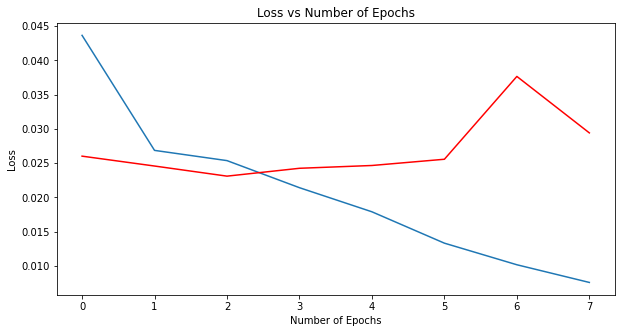

In [44]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(test_loss_set), 'r-', label="Test Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

Text(0.5, 1.0, 'Loss vs Number of Epochs')

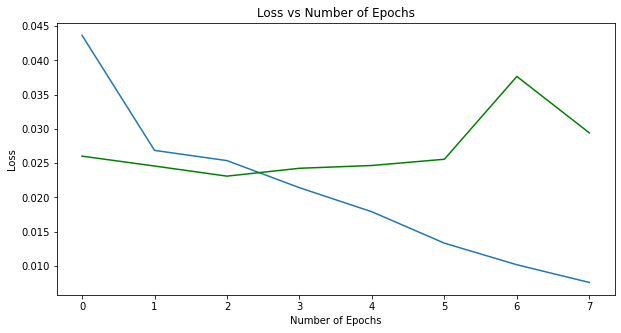

In [45]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Prediction on unlabeled dataset in supervised setting:

In [46]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

## Self Learning:

Step 1: First, train a XL-Net classifier on the labeled training data.

Step 2: Next, use the classifier to predict labels for all unlabeled data, as well as probabilities for those predictions. In this case, I will only adopt ‘pseudo-labels’ for predictions with greater than 92% probability.

Step 3: Concatenate the ‘pseudo-labeled’ data with the labeled training data, and re-train the classifier on the concatenated data.

Step 4: Use trained classifier to make predictions for the labeled test data, and evaluate the classifier.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.008514172178251664
Valid loss: 0.020168174220168072


Epoch:  25%|██▌       | 1/4 [00:57<02:53, 57.94s/it]

Saving model at epoch 0 with validation loss of 0.020168174220168072


Train loss: 0.00590380342728501


Epoch:  50%|█████     | 2/4 [01:43<01:48, 54.12s/it]

Valid loss: 0.026182604224785515


Train loss: 0.0021568861482408616


Epoch:  75%|███████▌  | 3/4 [02:28<00:51, 51.41s/it]

Valid loss: 0.036888767135046095


Train loss: 0.0013308127066092024


Epoch: 100%|██████████| 4/4 [03:13<00:00, 48.32s/it]

Valid loss: 0.03163176495581865


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 0
7589 high-probability predictions added to training data.
104 unlabeled instances remaining.

Train loss: 0.001561708271910012
Valid loss: 0.037965100096619644


Epoch:  25%|██▌       | 1/4 [00:46<02:20, 46.91s/it]

Saving model at epoch 0 with validation loss of 0.037965100096619644


Train loss: 0.0010244951617978057
Valid loss: 0.03361856030381244


Epoch:  50%|█████     | 2/4 [01:33<01:33, 46.89s/it]

Saving model at epoch 1 with validation loss of 0.03361856030381244


Train loss: 0.00041344742067635275
Valid loss: 0.0299485853832701


Epoch:  75%|███████▌  | 3/4 [02:20<00:46, 46.89s/it]

Saving model at epoch 2 with validation loss of 0.0299485853832701


Train loss: 0.0017359878330111265


Epoch: 100%|██████████| 4/4 [03:05<00:00, 46.42s/it]

Valid loss: 0.03564982440160668


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 1
98 high-probability predictions added to training data.
14 unlabeled instances remaining.

Train loss: 0.0036204346494438746
Valid loss: 0.025316691916921864


Epoch:  25%|██▌       | 1/4 [00:46<02:20, 46.98s/it]

Saving model at epoch 0 with validation loss of 0.025316691916921864


Train loss: 0.0018733373660856248


Epoch:  50%|█████     | 2/4 [01:32<01:32, 46.39s/it]

Valid loss: 0.02673822608978852


Train loss: 0.0007453544210608399


Epoch:  75%|███████▌  | 3/4 [02:17<00:45, 45.99s/it]

Valid loss: 0.027919634852720344


Train loss: 0.00039031187236872973


Epoch: 100%|██████████| 4/4 [03:02<00:00, 45.52s/it]

Valid loss: 0.03307090278552926


Now predicting labels for unlabeled data...



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration 2
14 high-probability predictions added to training data.
0 unlabeled instances remaining.

Train loss: 0.00025673335064231025
Valid loss: 0.033287536271888275


Epoch:  25%|██▌       | 1/4 [00:46<02:20, 46.99s/it]

Saving model at epoch 0 with validation loss of 0.033287536271888275


Train loss: 0.00019318379566076266


Epoch:  50%|█████     | 2/4 [01:32<01:32, 46.41s/it]

Valid loss: 0.034810682677704353


Train loss: 0.00018956722601406583


Epoch:  75%|███████▌  | 3/4 [02:17<00:46, 46.00s/it]

Valid loss: 0.03589873966753341


Train loss: 0.00016285958520986926


Epoch: 100%|██████████| 4/4 [03:02<00:00, 45.53s/it]

Valid loss: 0.03484599259884461


Now predicting labels for unlabeled data...
Iteration 3
0 high-probability predictions added to training data.
0 unlabeled instances remaining.



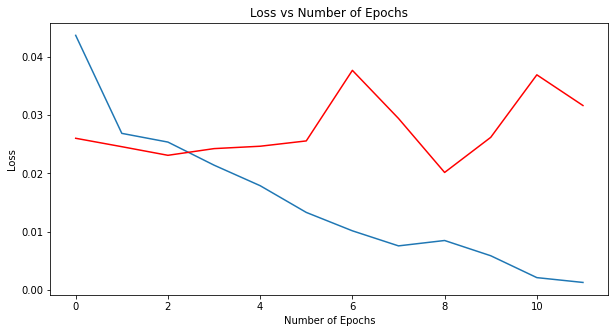

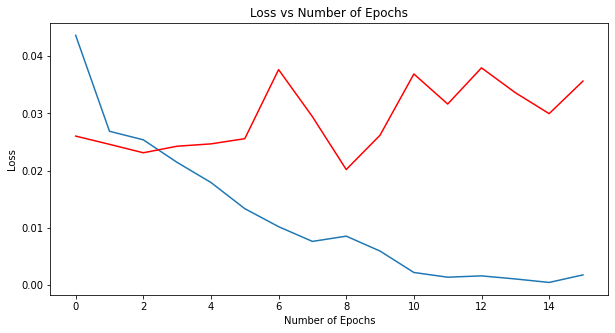

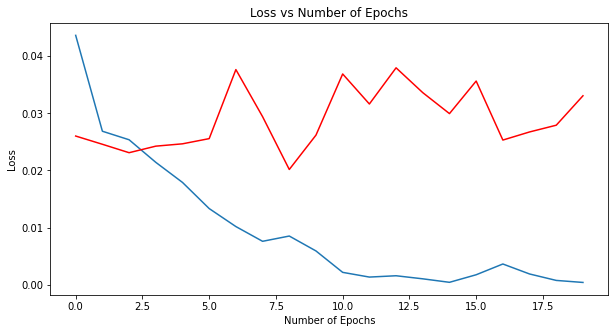

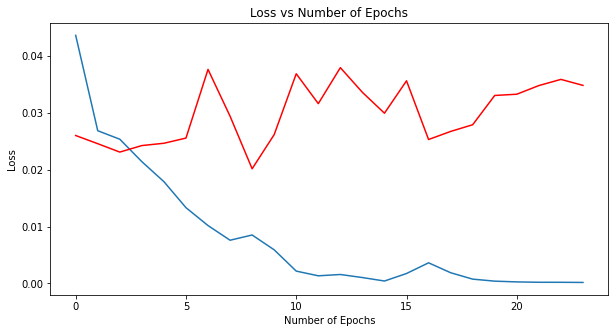

In [47]:
# Initiate iteration counter
iterations = 0
label_cols = ["Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"]
num_labels = len(label_cols)

# Containers to hold # of pseudo-labels
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    num_epochs=4

    cwd = os.getcwd()
    model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/processed_data/xlnet_toxic_2.bin")
    model, train_loss_set, test_loss_set =  train_model(model=model,\
                                                        num_epochs=num_epochs,\
                                                        optimizer=optimizer,\
                                                        train_dataloader=train_dataloader,\
                                                        valid_dataloader=test_dataloader,\
                                                        model_save_path=model_save_path,\
                                                        device="cuda")
    # Plot loss
    num_epochs = np.arange(len(train_loss_set))

    fig, ax = plt.subplots(figsize=(10, 5));
    ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
    ax.plot(num_epochs, np.array(test_loss_set), 'r-', label="Test Loss")
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Number of Epochs")

    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")
    pred_probs = generate_predictions(model, X_unlabeled, num_labels, device="cuda", batch_size=32)
    X_unlabeled["Dependencies_between_design_parameters"] = pred_probs[:,0]
    X_unlabeled["Effects_of_design_parameters_on_objectives"] = pred_probs[:,1]
    X_unlabeled["Exploration_of_design_parameter_values"] = pred_probs[:,2]
    X_unlabeled["Monitoring_objective_values"] = pred_probs[:,3]
    X_unlabeled["Selected_design_parameter_values_for_objective(s)"] = pred_probs[:,4]
    X_unlabeled["Tradeoff_between_objectives"] = pred_probs[:,5]


    # Calculate and print iteration 
    print(f"Iteration {iterations}")

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['Dependencies_between_design_parameters'] = X_unlabeled["Dependencies_between_design_parameters"]
    df_pred_prob['Effects_of_design_parameters_on_objectives'] = X_unlabeled["Effects_of_design_parameters_on_objectives"]
    df_pred_prob['Exploration_of_design_parameter_values'] = X_unlabeled["Exploration_of_design_parameter_values"]
    df_pred_prob['Monitoring_objective_values'] = X_unlabeled["Monitoring_objective_values"]
    df_pred_prob['Selected_design_parameter_values_for_objective(s)'] = X_unlabeled["Selected_design_parameter_values_for_objective(s)"]
    df_pred_prob['Tradeoff_between_objectives'] = X_unlabeled["Tradeoff_between_objectives"]
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 42% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['Dependencies_between_design_parameters'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Effects_of_design_parameters_on_objectives'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Exploration_of_design_parameter_values'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Monitoring_objective_values'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Selected_design_parameter_values_for_objective(s)'] > 0.42],
                           df_pred_prob.loc[df_pred_prob['Tradeoff_between_objectives'] > 0.42],], axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

In [48]:
len(X_train), len(X_unlabeled)

(8028, 0)

In [49]:
X_train.head(15)

full_text  ...                                              masks
393  how widely appreciable is the value change gai...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
413  the median current television broadcast factor...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
214  Can you see if you increase your bore diamater...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
134          what s your component range of weights ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
358               what s in your human factorofsafety?  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
437                 just lowered it down another 2 lbs  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
423  okay we re getting still above even a factor o...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
103  rn I only see our global factorofsafety as  0 ...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
226    bearingoffset equals to  60   dc equals to  15   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
36   just reduced thickness to reduce mass  increas...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
175  current broadcasted is  25   98   factorofsafe...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
84   flywheelthickness  equals to   10  mm ;  flywh...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
108              it depends heavily on piston diameter  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...
4         What value works best for your simulation ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
212  someone just broadcasted somethhing different ...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[15 rows x 9 columns]

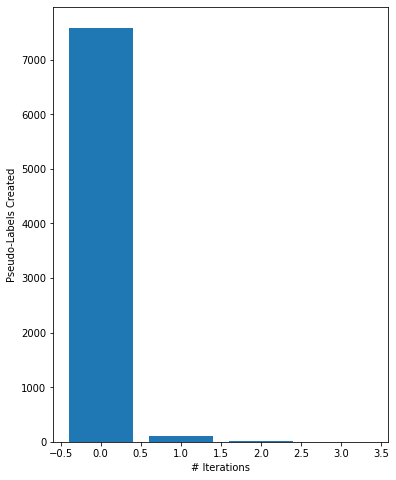

In [50]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, ax = plt.subplots(figsize=(6,8))
ax.bar(x=range(iterations), height=pseudo_labels)
ax.set_ylabel('Pseudo-Labels Created')
ax.set_xlabel('# Iterations');

## Final Dataset Output | Post-Processing:

In [67]:
X_train.drop(['features', 'masks'], axis = 1, inplace= True)
X_train['max_value'] = X_train.max_value

In [125]:
label = []
for j in range(len(X_train)):
  for i in X_train.columns:
    if X_train.iloc[j][i] == X_train.iloc[j]['max_value']:
      label.append(i)
      break

In [127]:
X_train['label'] = label

In [129]:
X_train.drop(["max_value","Dependencies_between_design_parameters", "Effects_of_design_parameters_on_objectives", "Exploration_of_design_parameter_values", "Monitoring_objective_values","Selected_design_parameter_values_for_objective(s)", "Tradeoff_between_objectives"], axis = 1, inplace= True)
X_train.reset_index(inplace=True)
X_train.drop(['index'], axis = 1, inplace= True)

In [133]:
X_train.head(2)

full_text                                              label
0  how widely appreciable is the value change gai...                        Tradeoff_between_objectives
1  the median current television broadcast factor...  Selected_design_parameter_values_for_objective(s)

In [134]:
X_train.to_csv('/content/drive/MyDrive/projects/Capstone_Project/Checkpoint_6/final_output_Q2.csv', index = False, sep = ',')